In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [3]:
def KMeans(K, data):
    d = np.size(data, axis=0)
    N = np.size(data, axis=1)
    I = np.eye(K)
    
    #Centra grup (losowe wektory z danych)
    #R = np.take(data, np.random.choice(np.arange(0,N), K, replace=False), axis=1)
    R = np.empty([d,K])
    choices = np.random.choice(np.arange(0,N), K, replace=False)
    for i in range(K):
        R[:,i] = data[:, choices[i]]
    #Przynależnosc do grupy (na poczatku wszyscy do zero)
    C = np.zeros((1,N), dtype=np.int64)
    #macierzPrzynaleznosci = np.zeros((N,K))

    iteration = 0
    groupsChanged = True
    while groupsChanged:
        iteration += 1
        #Interesuje nas minimalna wartość <r,r> -2<u,r>, gdzie u to wektor z danych a r to jakies centrum
        iloczynySkalarne = -2. * np.dot(data.T, R)
        R**=2
        kwadratyDlugosciR = np.sum(R, axis=0, keepdims=True)
        iloczynySkalarne += kwadratyDlugosciR

        #Dla kazdego wektora z danych wybieramy najblizszy wektor z R i aktualizujemy grupy
        newC = np.argmin(iloczynySkalarne, axis=1)
        groupsChanged = not np.array_equal(C, newC)
        C = newC

        #Obliczamy srodki ciezkosci dla kazdej grupy
        macierzPrzynaleznosci = np.take(I, C, axis=0)
        #Sumy danych w każdej z grup
        R = np.dot(data, macierzPrzynaleznosci)
        liczebnosciGrup = np.maximum(np.sum(macierzPrzynaleznosci, axis=0, keepdims=True), 1)
        R /= liczebnosciGrup

    print("Iterations:", iteration)
    return (C, R)

In [4]:
def generateData(N,d,K,p,mi,sigma):
    L = [np.linalg.cholesky(sigma[i]) for i in range(len(sigma))]
    choices = np.random.choice(np.arange(0,K), N, p=p)
    data = np.random.randn(d,N)
    
    #Jeśli X ~ N(mi, sigma) oraz Y = c + B*X, 
    #to Y ~ N(c + B * mi, B*sigma*B^T)
    #Jak wezmę X ~ N(zeros, I), c = mi oraz B = L, 
    #gdzie sigma = L*L^T, to otrzymam Y ~ N(mi + L*zeros, L*I*L^T) =
    # N(mi, L*L^T) = N(mi, sigma)
    
    for i in range(N):
        data[:,i] = mi[:,choices[i]] + np.dot(L[choices[i]], data[:,i])
        
    return data

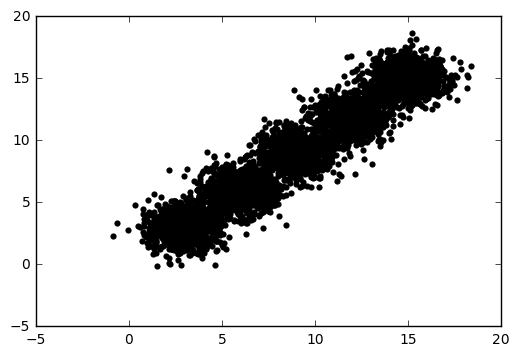

Iterations: 31


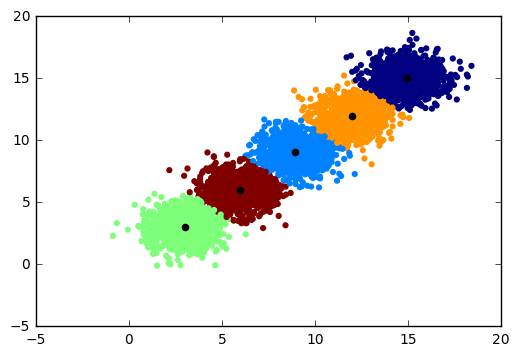

In [5]:
N = 5000
d = 2
K = 5
p = np.ones(K) / K
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]

data = generateData(N,d,K,p,mi,sigma)
plt.scatter(data[0,:], data[1,:], color="Black", marker='o', lw = 0)
plt.show()

groups, centers = KMeans(K, data)
plt.scatter(data[0,:], data[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.show()

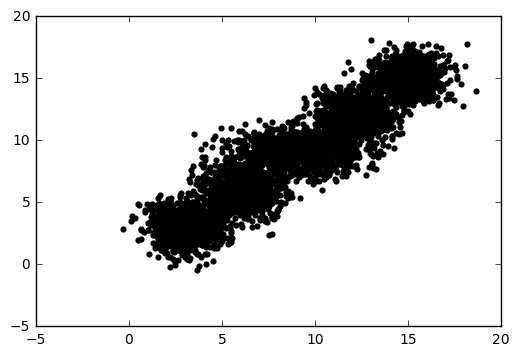

Iterations: 28


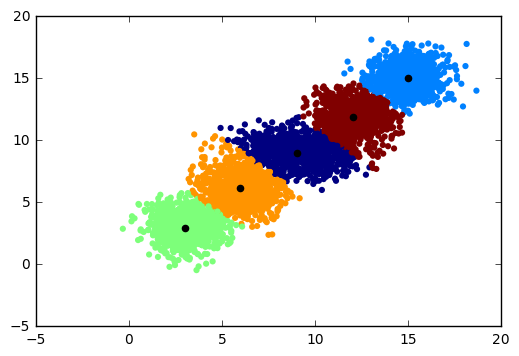

In [6]:
N = 5000
d = 2
K = 5
p = np.ones(K) / K
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]
sigma[2] = np.array([[3.,0.],[0.,1.]])

data = generateData(N,d,K,p,mi,sigma)
plt.scatter(data[0,:], data[1,:], color="Black", marker='o', lw = 0)
plt.show()

groups, centers = KMeans(K, data)
plt.scatter(data[0,:], data[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.show()

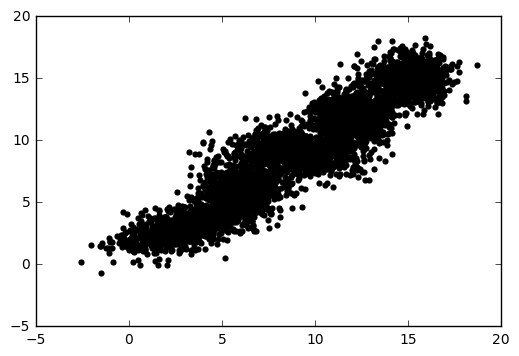

Iterations: 21


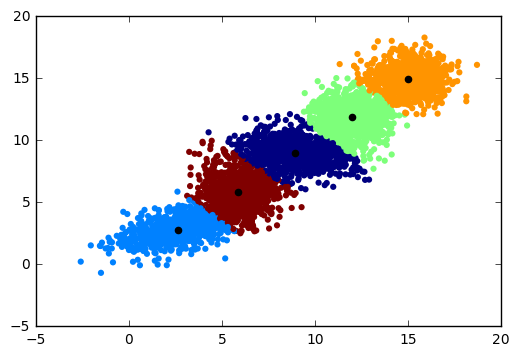

In [7]:
N = 5000
d = 2
K = 5
p = np.ones(K) / K
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]
sigma[0] = np.array([[3.,1.],[1.,1.]])
sigma[2] = np.array([[3.,0.],[0.,1.]])

data = generateData(N,d,K,p,mi,sigma)
plt.scatter(data[0,:], data[1,:], color="Black", marker='o', lw = 0)
plt.show()

groups, centers = KMeans(K, data)
plt.scatter(data[0,:], data[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.show()

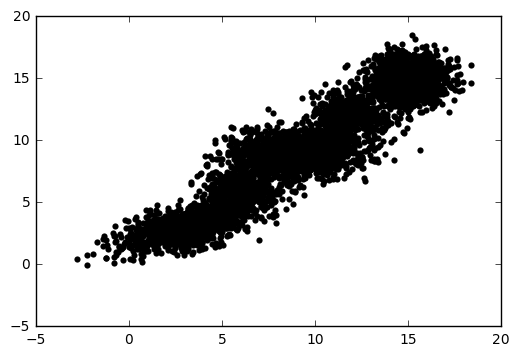

Iterations: 45


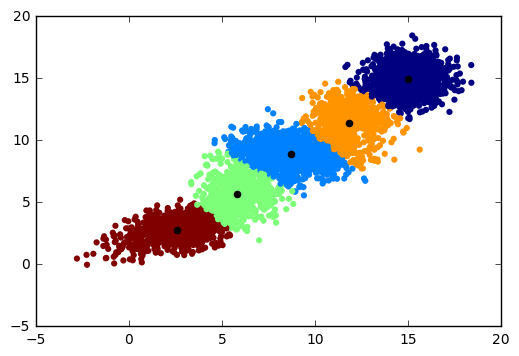

In [8]:
N = 5000
d = 2
K = 5
p = np.array([0.2, 0.1, 0.3, 0.1, 0.3])
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]
sigma[0] = np.array([[3.,1.],[1.,1.]])
sigma[2] = np.array([[3.,0.],[0.,1.]])

data = generateData(N,d,K,p,mi,sigma)
plt.scatter(data[0,:], data[1,:], color="Black", marker='o', lw = 0)
plt.show()

groups, centers = KMeans(K, data)
plt.scatter(data[0,:], data[1,:], c=groups, marker='o', lw = 0)
plt.scatter(centers[0,:], centers[1,:], c="Black", marker='o', lw = 1)
plt.show()

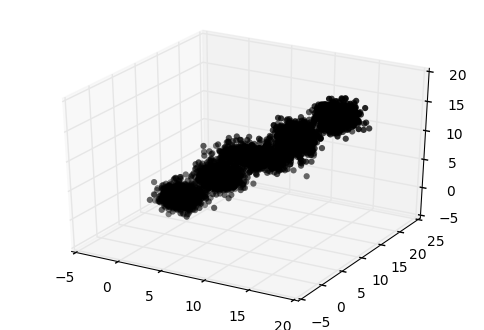

Iterations: 41


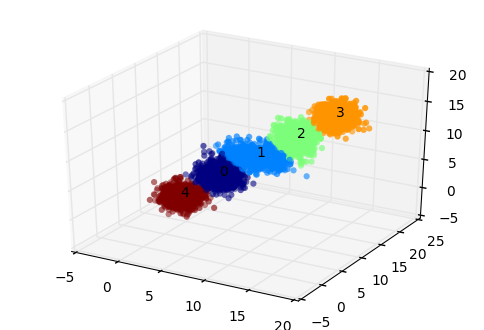

In [9]:
N = 5000
d = 3
K = 5
p = np.ones(K) / K
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]
sigma[2] = np.array([[3,1,0],[1,1,0],[0,0,1]], dtype=np.float64)

data = generateData(N,d,K,p,mi,sigma)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[0,:], data[1,:], zs=data[2,:], color="Black", marker='o', lw = 0)
plt.show()

groups, centers = KMeans(K, data)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[0,:], data[1,:], zs=data[2,:], c=groups, marker='o', lw = 0)
ax.scatter(centers[0,:], centers[1,:], zs=centers[2,:], c="Black", marker='o', lw = 1)
for i in range(K):
    ax.text(centers[0,i], centers[1,i], centers[2,i], str(i))
plt.show()

In [10]:
N = 5000
d = 100
K = 10
p = np.ones(K) / K
mi = np.repeat(3*np.arange(1,K+1)[np.newaxis], d, axis=0)
sigma = [np.eye(d) for i in range(1,K+1)]

data = generateData(N,d,K,p,mi,sigma)

#for i in range(d):
#    for j in range(d):
#        plt.subplot(d, d, i*d+j+1)
#        plt.plot(data[i, :], data[j, :], 'bo')
#plt.show()

startT = time.time()
groups, centers = KMeans(K, data)
endT = time.time()
print("K-Means took %s to compute" % (endT - startT))

#for i in range(d):
#    for j in range(d):
#        plt.subplot(d, d, i*d+j+1)
#        plt.plot(data[i, :], data[j, :], c=groups)
#        plt.plot(centers[i, :], centers[j, :], 'bo')
#plt.show()

Iterations: 22
K-Means took 0.07589387893676758 to compute
